In [38]:
import rich
from rich import print
import wandb
import fastai
from fastai.vision.all import *
from fastai.callback.wandb import WandbCallback

# CamVid

In [2]:
path = untar_data(URLs.CAMVID)

In [3]:
codes = np.loadtxt(path/'codes.txt', dtype=str)
fnames = get_image_files(path/"images")

In [4]:
def label_func(fn): return path/"labels"/f"{fn.stem}_P{fn.suffix}"

tfms = aug_transforms()

dls = SegmentationDataLoaders.from_label_func(
    path, bs=16, fnames = fnames, 
    label_func = label_func, codes = codes, 
    item_tfms=Resize((360//2,480//2)),
    batch_tfms=tfms,
)

In [5]:
x,y = dls.one_batch()
x.shape

torch.Size([16, 3, 180, 240])

In [6]:
# logger = WandbCallback()
learn = unet_learner(dls, 
                     resnet34, 
                     metrics=[DiceMulti(), foreground_acc],
                     # loss_func=FocalLoss(),
                     ).to_fp16()

In [7]:
learn.fine_tune(1)

epoch,train_loss,valid_loss,dice_multi,foreground_acc,time
0,2.543366,1.654186,0.065953,0.520173,00:13


epoch,train_loss,valid_loss,dice_multi,foreground_acc,time
0,1.394403,1.163370,0.080619,0.638435,00:08


Log to wandb

## Table

In [19]:
class_labels = {i:c for i,c in enumerate(codes)}

In [20]:
def get_preds(learn):
    inp,preds,targs,out = learn.get_preds(with_input=True, with_decoded=True)
    b = tuplify(inp) + tuplify(targs)
    x,y,samples,outs = dls.valid.show_results(b, out, show=False, max_n=36)
    class_labels = {i:code for i,code in enumerate(codes)}
    return samples, outs, preds

In [21]:
def create_table(samples, outs, preds):
    "Creates a wandb table with preds and targets side by side"
    res = []
    table = wandb.Table(columns=["image", "preds", "targets"])
    for (image, label), pred_label in zip(samples, outs):
        img = image.permute(1,2,0)
        table.add_data(wandb.Image(img),
                       wandb.Image(img, masks={"pred":  {'mask_data':  pred_label[0].numpy(), 'class_labels':class_labels}}),
                       wandb.Image(img, masks={"target": {'mask_data': label.numpy(), 'class_labels':class_labels}}))
    return table

In [22]:
samples, outs, preds = get_preds(learn)

In [23]:
table = create_table(samples, outs, preds)

In [24]:
# with wandb.init(project="wandb_image"):
#     wandb.log({"preds_table": table})

In [49]:
class CombinedLoss:
    "Dice and Focal combined"
    def __init__(self, axis=1, smooth=1, alpha=1):
        store_attr()
        self.focal_loss = FocalLossFlat(axis=axis)
        self.dice_loss =  DiceLoss(axis, smooth)
        
    def __call__(self, pred, targ):
        return self.focal_loss(pred, targ) + self.alpha * self.dice_loss(pred, targ)
    
    def decodes(self, x):    return x.argmax(dim=self.axis)
    def activation(self, x): return F.softmax(x, dim=self.axis)

## Prepare for sweep

In [81]:
#ready for sweeps
config = {"arch": "resnet34",
          "batch_size": 16,
          "loss_func": "CrossEntropyLossFlat",
          "lr": 0.002,
          "resize_factor":4}

def run_train(config=None):
    with wandb.init(config=config):
        config = wandb.config
        logger = WandbCallback()
        
        # dataloaders
        tfms = aug_transforms()
        dls = SegmentationDataLoaders.from_label_func(
            path, 
            bs=config.batch_size, 
            fnames = fnames, 
            label_func = label_func, 
            codes = codes, 
            item_tfms = Resize((720//config.resize_factor, 
                                960//config.resize_factor)),
            batch_tfms = tfms,
        )

        # model
        cbs = [logger, MixedPrecision()]
        
        loss_func = getattr(fastai.losses, config.loss_func)(axis=1)
        model = {"resnet34":resnet34, "xresnet34":xresnet34, "xresnext34":xresnext34}
        learn = unet_learner(dls, 
                             model[config.arch],
                             metrics = [DiceMulti(), foreground_acc],
                             loss_func = loss_func,
                             cbs = cbs)
        learn.fine_tune(10, base_lr=config.lr)
        
        table = create_table(*get_preds(learn))
        
        wandb.log({"Predictions":table})

In [82]:
sweep_config = {
    'method': 'bayes',
    'metric': {
        'name': 'valid_loss',
        'goal': 'minimize'   
    }
}

    
parameters = {
    'lr': {# a flat distribution between 0 and 0.1
            'distribution': 'uniform',
            'min': 0,
            'max': 0.1
      },
    'batch_size': {
        "values": [8,16,32]
    },
    'arch':{
        "values": ["resnet34", "xresnet34", "xresnext34"]
    },
    'loss_func': {
        "values": ["CrossEntropyLossFlat", "FocalLoss"]
    },
    'resize_factor':{
        "value": 4
    }
}

In [83]:
# run_train("camvid", entity="hydranet", config=config)

In [84]:
sweep_config["parameters"] = parameters

In [85]:
print(sweep_config)

{
    'method': 'bayes',
    'metric': {'name': 'valid_loss', 'goal': 'minimize'},
    'parameters': {
        'lr': {'distribution': 'uniform', 'min': 0, 'max': 0.1},
        'batch_size': {'values': [8, 16, 32]},
        'arch': {'values': ['resnet34', 'xresnet34', 'xresnext34']},
        'loss_func': {'values': ['CrossEntropyLossFlat', 'FocalLossFlat']},
        'resize_factor': {'value': 4}
    }
}

In [86]:
sweep_id = wandb.sweep(sweep_config, project="camvid", entity="hydranet")

Create sweep with ID: jz9h34ve
Sweep URL: https://wandb.ai/hydranet/CamVid/sweeps/jz9h34ve


In [87]:
wandb.agent(sweep_id, run_train, count=30)

wandb: Agent Starting Run: 9kc9fexo with config:
wandb: 	arch: xresnext34
wandb: 	batch_size: 32
wandb: 	loss_func: FocalLossFlat
wandb: 	lr: 0.06324001470640281
wandb: 	resize_factor: 4
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


WandbCallback requires use of "SaveModelCallback" to log best model


epoch,train_loss,valid_loss,dice_multi,foreground_acc,time
0,nan,nan,0.016186,0.262737,00:12


epoch,train_loss,valid_loss,dice_multi,foreground_acc,time
0,nan,nan,0.012639,0.123082,00:09


wandb: Ctrl + C detected. Stopping sweep.


dice_multi,█▁
epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
eps_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eps_1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
foreground_acc,█▁
lr_0,▁▁▁▂▂▃▃▄▄▅▆▆▇▇███▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr_1,▁▁▁▂▂▂▃▄▄▅▆▆▇▇███▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂
mom_0,███▇▇▇▆▅▅▄▃▃▂▂▁▁▁█████████▇▇▇▇▇▇▇▆▆▆▆
mom_1,███▇▇▇▆▅▅▄▃▃▂▂▁▁▁█████████▇▇▇▇▇▇▇▆▆▆▆
raw_loss,▁
sqr_mom_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁


## MLP

In [106]:
from torch import nn
from functools import partial
from einops.layers.torch import Rearrange, Reduce

class PreNormResidual(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.fn = fn
        self.norm = nn.LayerNorm(dim)

    def forward(self, x):
        return self.fn(self.norm(x)) + x

def FeedForward(dim, expansion_factor = 4, dropout = 0., dense = nn.Linear):
    return nn.Sequential(
        dense(dim, dim * expansion_factor),
        nn.GELU(),
        nn.Dropout(dropout),
        dense(dim * expansion_factor, dim),
        nn.Dropout(dropout)
    )

def MLPSegmentationMixer(image_size, channels, patch_size, dim, depth, out_channels=3, expansion_factor = 4, dropout = 0.):
    assert (image_size[0] % patch_size) == 0, 'image must be divisible by patch size'
    h, w = (image_size[0] // patch_size) , (image_size[1] // patch_size) 
    num_patches = h*w
    chan_first, chan_last = partial(nn.Conv1d, kernel_size = 1), nn.Linear

    return nn.Sequential(
        Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1 = patch_size, p2 = patch_size),
        nn.Linear((patch_size ** 2) * channels, dim),
        *[nn.Sequential(
            PreNormResidual(dim, FeedForward(num_patches, expansion_factor, dropout, chan_first)),
            PreNormResidual(dim, FeedForward(dim, expansion_factor, dropout, chan_last))
        ) for _ in range(depth)],
        nn.LayerNorm(dim),
        nn.Linear(dim, (patch_size ** 2) * out_channels),
        Rearrange('b (h w) (p1 p2 c) -> b c (h p1) (w p2)', c=out_channels, h=h, p1 = patch_size, p2 = patch_size),
    )

In [134]:
mlp_mixer = MLPSegmentationMixer((180, 240), 3, 20, 1024, 6, len(codes))

In [135]:
dls = SegmentationDataLoaders.from_label_func(
    path, bs=64, fnames = fnames, label_func = label_func, codes = codes, item_tfms=Resize((360//2,480//2))
)

In [136]:
learn2 = Learner(dls, mlp_mixer, loss_func=CrossEntropyLossFlat(axis=1), metrics=[DiceMulti(), foreground_acc])

SuggestedLRs(valley=0.00013182566908653826)

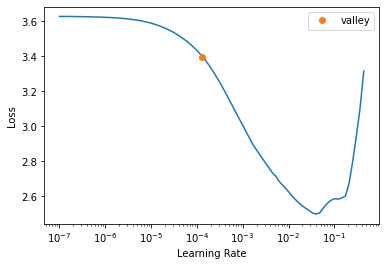

In [137]:
learn2.lr_find()

In [133]:
learn2.fit_one_cycle(10, 1e-2)

epoch,train_loss,valid_loss,dice_multi,foreground_acc,time
0,2.150888,1.486428,0.072149,0.571200,00:05
1,1.547103,1.171696,0.107280,0.602114,00:05
2,1.290867,1.061671,0.134800,0.676842,00:06
3,1.119405,0.917001,0.165706,0.728370,00:05
4,0.979992,0.850557,0.220480,0.744956,00:05
5,0.873434,0.780932,0.238645,0.766857,00:06
6,0.784772,0.737917,0.257262,0.783211,00:05
7,0.719835,0.716319,0.281181,0.786466,00:05


Exception ignored in: <function _releaseLock at 0x7f85733f23a0>
Traceback (most recent call last):
  File "/home/paperspace/mambaforge/envs/fastai/lib/python3.9/logging/__init__.py", line 227, in _releaseLock
    def _releaseLock():
KeyboardInterrupt: 


RuntimeError: DataLoader worker (pid(s) 20016) exited unexpectedly